## Importing some packages

In [384]:
import os.path
import numpy as np
import pandas as pd

from scipy.stats import ttest_ind, ttest_rel
import matplotlib.pyplot as plt
from matplotlib.transforms import Affine2D
from statsmodels.stats.contingency_tables import mcnemar

from config import *

## Loading the data

In [385]:
results_general = pd.read_csv(os.path.join(work_dir, 'results_general2.csv'))
results_spherical = pd.read_csv(os.path.join(work_dir, 'results_spherical2.csv'))

## Setting some global parameters

In [386]:
figsize= (10.5, 2)

## General distortions

### Plotting the figure of matching exact and simulated figures and AUC scores

relative variation for noisy window b
2                 1.4e-02
5                 3.3e-03
sturges-formula   6.0e-03
rice-rule         8.1e-03
square-root       4.1e-03
dtype: float64
relative variation for distorted template (general distortion) b
2                 3.7e-03
5                 2.6e-03
sturges-formula   1.8e-03
rice-rule         1.2e-03
square-root       5.8e-04
dtype: float64


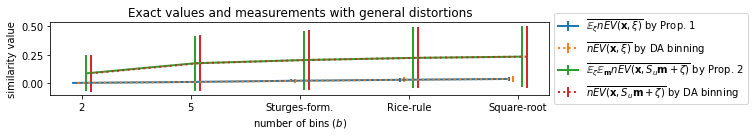

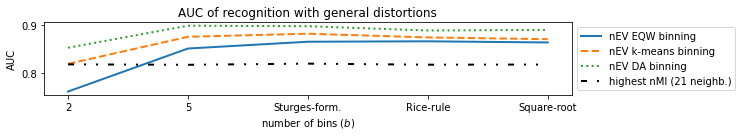

In [387]:
grouped= results_general.groupby(['b']).agg(['mean', 'std'])

grouped= grouped.loc[['2', '5', 'sturges-formula', 'rice-rule', 'square-root']]

print('relative variation for noisy window', abs(grouped[('exact_noise', 'mean')] - grouped[('distortion_aligned_noise', 'mean')])/grouped[('exact_noise', 'mean')])
print('relative variation for distorted template (general distortion)', abs(grouped[('exact_distortion', 'mean')] - grouped[('distortion_aligned_distorted', 'mean')])/grouped[('distortion_aligned_distorted', 'mean')])

fig, ax= plt.subplots(figsize=figsize)
trans0= Affine2D().translate(-0.08, 0.0) + ax.transData
trans1= Affine2D().translate(-0.04, 0.0) + ax.transData
trans2= Affine2D().translate(-0.0, 0.0) + ax.transData
trans3= Affine2D().translate(0.04, 0.0) + ax.transData
trans4= Affine2D().translate(0.08, 0.0) + ax.transData

ax.errorbar(np.arange(len(grouped)), grouped[('exact_noise', 'mean')], grouped[('exact_noise', 'std')], label='$\\overline{\\mathbb{E}_\\xi nEV(\\mathbf{x},\\xi)}$ by Prop. 1', linestyle='-', linewidth=2.0, transform=trans0)
ax.errorbar(np.arange(len(grouped)), grouped[('distortion_aligned_noise', 'mean')], grouped[('distortion_aligned_noise', 'std')], label='$\\overline{nEV(\\mathbf{x}, \\xi)}$ by DA binning', linewidth=2.0, linestyle=':', transform=trans1)
ax.errorbar(np.arange(len(grouped)), grouped[('exact_distortion', 'mean')], grouped[('exact_distortion', 'std')], label='$\\overline{\\mathbb{E}_\\zeta\\mathbb{E}_\\mathbf{m} nEV(\\mathbf{x}, S_u \\mathbf{m} + \\zeta)}$ by Prop. 2', linestyle='solid', linewidth=2.0, transform=trans3)
ax.errorbar(np.arange(len(grouped)), grouped[('distortion_aligned_distorted', 'mean')], grouped[('distortion_aligned_distorted', 'std')], label='$\\overline{nEV(\\mathbf{x}, S_u \\mathbf{m} + \\zeta)}$ by DA binning', linewidth=2.0, linestyle=':', transform=trans4)
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
ax.set_xlabel('number of bins ($b$)')
ax.set_ylabel('similarity value')
ax.set_title('Exact values and measurements with general distortions')
ax.set_xticks(np.arange(len(grouped)))
ax.set_xticklabels(['2', '5', 'Sturges-form.', 'Rice-rule', 'Square-root'])
plt.tight_layout()
plt.savefig('fit_general.pdf')

plt.figure(figsize=figsize)
plt.plot(np.arange(len(grouped)), grouped[('eqw_hits', 'mean')], label='nEV EQW binning', linestyle='-', linewidth=2.0)
#plt.plot(np.arange(len(grouped)), grouped[('eqf_hits', 'mean')], label='nEV EQF binning', linewidth=2.0, linestyle='-.')
plt.plot(np.arange(len(grouped)), grouped[('kmeans_hits', 'mean')], label='nEV k-means binning', linestyle='--', linewidth=2.0)
plt.plot(np.arange(len(grouped)), grouped[('distortion_aligned_hits', 'mean')], label='nEV DA binning', linewidth=2.0, linestyle=':')

nmi_values= []
for i, n in enumerate(mi_n_neighbors_simulation_general):
    nmi_values.append(np.mean(grouped[('mi_' + str(n) + '_hits', 'mean')]))
highest_nmi= mi_n_neighbors_simulation_general[np.argmax(nmi_values)]
i= 5
n= highest_nmi
    
plt.plot(np.arange(len(grouped)), grouped[('mi_' + str(n) + '_hits', 'mean')], label='highest nMI (' + str(n) + ' neighb.)', linewidth=2.0, linestyle=['-', '-.', '--', ':', (0, (3, 10, 1, 10)), (0, (3, 5, 1, 5, 1, 5)), (0, (3, 1, 1, 1, 1, 1))][i], c='black')

plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.xlabel('number of bins ($b$)')
plt.ylabel('AUC')
plt.title('AUC of recognition with general distortions')
plt.xticks(np.arange(len(grouped)), ['2', '5', 'Sturges-form.', 'Rice-rule', 'Square-root'])
plt.tight_layout()
plt.savefig('auc_general.pdf')

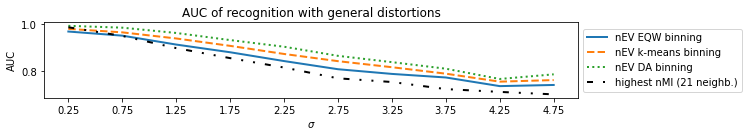

In [388]:
sigma_hist= np.histogram(results_general['sigma'], bins=10, range=[0, np.max(results_general['sigma']) + 1e-5])
results_general['sigma_bin']= np.digitize(results_general['sigma'], sigma_hist[1], right=False)

sigma_values= (sigma_hist[1][1:] + sigma_hist[1][:-1])/2

grouped_sigma= results_general.groupby(['sigma_bin']).agg(['mean', 'std'])

grouped_sigma= grouped_sigma.loc[list(np.unique(results_general['sigma_bin']))]

plt.figure(figsize=figsize)
plt.plot(np.arange(len(grouped_sigma)), grouped_sigma[('eqw_hits', 'mean')], label='nEV EQW binning', linestyle='-', linewidth=2.0)
#plt.plot(np.arange(len(grouped)), grouped[('eqf_hits', 'mean')], label='nEV EQF binning', linewidth=2.0, linestyle='-.')
plt.plot(np.arange(len(grouped_sigma)), grouped_sigma[('kmeans_hits', 'mean')], label='nEV k-means binning', linestyle='--', linewidth=2.0)
plt.plot(np.arange(len(grouped_sigma)), grouped_sigma[('distortion_aligned_hits', 'mean')], label='nEV DA binning', linewidth=2.0, linestyle=':')

nmi_values= []
for i, n in enumerate(mi_n_neighbors_simulation_general):
    nmi_values.append(np.mean(grouped_sigma[('mi_' + str(n) + '_hits', 'mean')]))
highest_nmi= mi_n_neighbors_simulation_general[np.argmax(nmi_values)]
i= 5
n= highest_nmi
    
plt.plot(np.arange(len(grouped_sigma)), grouped_sigma[('mi_' + str(n) + '_hits', 'mean')], label='highest nMI (' + str(n) + ' neighb.)', linewidth=2.0, linestyle=['-', '-.', '--', ':', (0, (3, 10, 1, 10)), (0, (3, 5, 1, 5, 1, 5)), (0, (3, 1, 1, 1, 1, 1))][i], c='black')

plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.xlabel('$\sigma$')
plt.ylabel('AUC')
plt.title('AUC of recognition with general distortions')
plt.xticks(np.arange(len(grouped_sigma)), [str(np.round(s, 2)) for s in sigma_values])
plt.tight_layout()
plt.savefig('sigma_general.pdf')

### Executing the statistical tests

In [389]:
results_general.columns

Index(['d', 'b', 'b_mods', 'sigma', 'sigma_m', 'exact_noise',
       'exact_distortion', 'exact_kmeans', 'steps', 'd_tau', 'id', 'eqw_noise',
       'eqw_distorted', 'eqw_hits', 'eqw_runtime', 'eqf_noise',
       'eqf_distorted', 'eqf_hits', 'eqf_runtime', 'kmeans_noise',
       'kmeans_distorted', 'kmeans_hits', 'kmeans_runtime',
       'distortion_aligned_noise', 'distortion_aligned_distorted',
       'distortion_aligned_hits', 'distortion_aligned_runtime', 'mi_3_hits',
       'mi_3_runtime', 'mi_7_hits', 'mi_7_runtime', 'mi_11_hits',
       'mi_11_runtime', 'mi_21_hits', 'mi_21_runtime', 'sigma_bin'],
      dtype='object')

In [390]:
results_square_root= results_general[results_general['b'] == 'square-root']

means= np.array([np.mean(results_general['eqw_hits']), 
                 np.mean(results_general['eqf_hits']), 
                 np.mean(results_general['kmeans_hits']), 
                 np.mean(results_general['distortion_aligned_hits']),
                 np.mean(results_general['mi_3_hits']),
                 np.mean(results_general['mi_7_hits']),
                 np.mean(results_general['mi_11_hits']),
                 np.mean(results_general['mi_21_hits'])])

binning_methods_mi= binning_methods + ['mi_' + str(i) for i in mi_n_neighbors_simulation_general]

p_matrix_general= np.zeros(shape=(len(binning_methods_mi), len(binning_methods_mi)))

for i, b0 in enumerate(binning_methods_mi):
    for j, b1 in enumerate(binning_methods_mi):
        p_matrix_general[i][j]= ttest_rel(results_square_root[b0 + '_hits'], results_square_root[b1 + '_hits'])[1]

pd.options.display.float_format = '{:.1e}'.format
p= pd.DataFrame(np.vstack([p_matrix_general, means]), 
                columns= binning_methods_mi, 
                index=binning_methods_mi + ['AUC']).fillna(1)

print("the matrix of p-values and mean AUCs for general distortions with paired t-test")
print(p.to_latex())

p_matrix_general= np.zeros(shape=(len(binning_methods_mi), len(binning_methods_mi)))

table= np.zeros(shape=(2,2))

for i, b0 in enumerate(binning_methods_mi):
    for j, b1 in enumerate(binning_methods_mi):
        a= results_square_root[b0 + '_hits'].values
        b= results_square_root[b1 + '_hits'].values

        for k in [0, 1]:
            for l in [0, 1]:
                table[k,l]= np.sum(np.logical_and(a == k, b == l))

        p_matrix_general[i][j]= mcnemar(table).pvalue

pd.options.display.float_format = '{:.1e}'.format
p= pd.DataFrame(np.vstack([p_matrix_general, means]), 
                columns= binning_methods_mi, 
                index=binning_methods_mi + ['AUC']).fillna(1)

print("the matrix of p-values and mean AUCs for general distortions with mcnemar test")
print(p.to_latex())


the matrix of p-values and mean AUCs for general distortions with paired t-test
\begin{tabular}{lrrrrrrrr}
\toprule
{} &      eqw &      eqf &   kmeans &  distortion\_aligned &     mi\_3 &     mi\_7 &   mi\_11 &   mi\_21 \\
\midrule
eqw                &  1.0e+00 &  0.0e+00 &  2.9e-02 &             1.5e-14 & 2.8e-118 &  1.6e-62 & 1.6e-43 & 1.0e-26 \\
eqf                &  0.0e+00 &  1.0e+00 &  0.0e+00 &             0.0e+00 & 1.1e-291 &  0.0e+00 & 0.0e+00 & 0.0e+00 \\
kmeans             &  2.9e-02 &  0.0e+00 &  1.0e+00 &             3.4e-09 & 3.3e-135 &  9.6e-78 & 2.3e-55 & 4.2e-35 \\
distortion\_aligned &  1.5e-14 &  0.0e+00 &  3.4e-09 &             1.0e+00 & 2.3e-186 & 9.4e-115 & 4.1e-90 & 3.5e-64 \\
mi\_3               & 2.8e-118 & 1.1e-291 & 3.3e-135 &            2.3e-186 &  1.0e+00 &  5.4e-16 & 3.8e-28 & 7.3e-45 \\
mi\_7               &  1.6e-62 &  0.0e+00 &  9.6e-78 &            9.4e-115 &  5.4e-16 &  1.0e+00 & 3.1e-05 & 2.7e-13 \\
mi\_11              &  1.6e-43 &  0.0e+00 &  2.3e-

In [391]:
tmp=results_general[['b'] + [c for c in results_general.columns if c.endswith('hits')]].groupby(['b']).mean().T
print(tmp)
print(tmp.mean(axis=1))

b                             2       5  rice-rule  square-root  \
eqw_hits                7.6e-01 8.5e-01    8.7e-01      8.6e-01   
eqf_hits                5.0e-01 5.0e-01    4.9e-01      5.0e-01   
kmeans_hits             8.2e-01 8.8e-01    8.7e-01      8.7e-01   
distortion_aligned_hits 8.5e-01 9.0e-01    8.9e-01      8.9e-01   
mi_3_hits               7.5e-01 7.5e-01    7.5e-01      7.5e-01   
mi_7_hits               7.9e-01 7.9e-01    7.9e-01      7.9e-01   
mi_11_hits              8.0e-01 8.0e-01    8.0e-01      8.0e-01   
mi_21_hits              8.2e-01 8.2e-01    8.2e-01      8.2e-01   

b                        sturges-formula  
eqw_hits                         8.7e-01  
eqf_hits                         5.1e-01  
kmeans_hits                      8.8e-01  
distortion_aligned_hits          9.0e-01  
mi_3_hits                        7.5e-01  
mi_7_hits                        7.8e-01  
mi_11_hits                       8.0e-01  
mi_21_hits                       8.2e-01  
eqw_hits 

## Spherical distortions

### Plotting the figure of matching exact and simulated figures and AUC scores

relative variation for noisy window b
2                 1.3e-02
5                 1.2e-03
sturges-formula   5.6e-03
rice-rule         8.2e-04
square-root       2.4e-04
dtype: float64
relative variation for distorted template (spherical distortion) b
2                 5.5e-01
5                 1.6e-02
sturges-formula   4.2e-04
rice-rule         2.0e-03
square-root       2.7e-03
dtype: float64


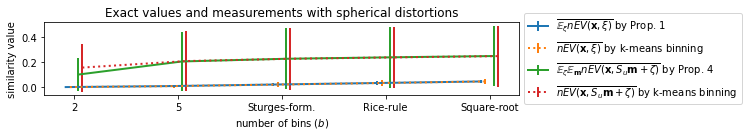

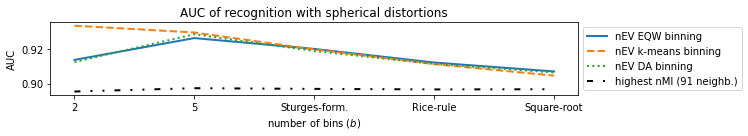

In [392]:
grouped= results_spherical.groupby(['b']).agg(['mean', 'std'])

grouped= grouped.loc[['2', '5', 'sturges-formula', 'rice-rule', 'square-root']]

print('relative variation for noisy window', abs(grouped[('exact_noise', 'mean')] - grouped[('kmeans_noise', 'mean')])/grouped[('exact_noise', 'mean')])
print('relative variation for distorted template (spherical distortion)', abs(grouped[('exact_kmeans', 'mean')] - grouped[('kmeans_distorted', 'mean')])/grouped[('exact_kmeans', 'mean')])

fig, ax= plt.subplots(figsize=figsize)
trans0= Affine2D().translate(-0.08, 0.0) + ax.transData
trans1= Affine2D().translate(-0.04, 0.0) + ax.transData
trans2= Affine2D().translate(-0.0, 0.0) + ax.transData
trans3= Affine2D().translate(0.04, 0.0) + ax.transData
trans4= Affine2D().translate(0.08, 0.0) + ax.transData
trans5= Affine2D().translate(0.12, 0.0) + ax.transData

ax.errorbar(np.arange(len(grouped)), grouped[('exact_noise', 'mean')], grouped[('exact_noise', 'std')], label='$\\overline{\\mathbb{E}_\\xi nEV(\\mathbf{x},\\xi)}$ by Prop. 1', linestyle='-', linewidth=2.0, transform=trans0)
ax.errorbar(np.arange(len(grouped)), grouped[('kmeans_noise', 'mean')], grouped[('kmeans_noise', 'std')], label='$\\overline{nEV(\\mathbf{x}, \\xi)}$ by k-means binning', linewidth=2.0, linestyle=':', transform=trans1)
ax.errorbar(np.arange(len(grouped)), grouped[('exact_kmeans', 'mean')], grouped[('exact_kmeans', 'std')], label='$\\overline{\\mathbb{E}_\\zeta\\mathbb{E}_\\mathbf{m} nEV(\\mathbf{x}, S_u \\mathbf{m} + \\zeta)}$ by Prop. 4', linestyle='solid', linewidth=2.0, transform=trans3)
ax.errorbar(np.arange(len(grouped)), grouped[('kmeans_distorted', 'mean')], grouped[('kmeans_distorted', 'std')], label='$\\overline{nEV(\\mathbf{x}, S_u \\mathbf{m} + \\zeta)}$ by k-means binning', linewidth=2.0, linestyle=':', transform=trans4)
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
ax.set_xlabel('number of bins ($b$)')
ax.set_ylabel('similarity value')
ax.set_title('Exact values and measurements with spherical distortions')
ax.set_xticks(np.arange(len(grouped)))
ax.set_xticklabels(['2', '5', 'Sturges-form.', 'Rice-rule', 'Square-root'])
plt.tight_layout()
plt.savefig('fit_spherical.pdf')

plt.figure(figsize=figsize)
plt.plot(np.arange(len(grouped)), grouped[('eqw_hits', 'mean')], label='nEV EQW binning', linestyle='-', linewidth=2.0)
#plt.plot(np.arange(len(grouped)), grouped[('eqf_hits', 'mean')], label='nEV EQF binning', linewidth=2.0, linestyle='-.')
plt.plot(np.arange(len(grouped)), grouped[('kmeans_hits', 'mean')], label='nEV k-means binning', linestyle='--', linewidth=2.0)
plt.plot(np.arange(len(grouped)), grouped[('distortion_aligned_hits', 'mean')], label='nEV DA binning', linewidth=2.0, linestyle=':')
nmi_values= []
for i, n in enumerate(mi_n_neighbors_simulation_spherical):
    nmi_values.append(np.mean(grouped[('mi_' + str(n) + '_hits', 'mean')]))
highest_nmi= mi_n_neighbors_simulation_spherical[np.argmax(nmi_values)]
i= 5
n= highest_nmi
    
plt.plot(np.arange(len(grouped)), grouped[('mi_' + str(n) + '_hits', 'mean')], label='highest nMI (' + str(n) + ' neighb.)', linewidth=2.0, linestyle=['-', '-.', '--', ':', (0, (3, 10, 1, 10)), (0, (3, 5, 1, 5, 1, 5)), (0, (3, 1, 1, 1, 1, 1))][i], c='black')

plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.xlabel('number of bins ($b$)')
plt.ylabel('AUC')
plt.title('AUC of recognition with spherical distortions')
plt.xticks(np.arange(len(grouped)), ['2', '5', 'Sturges-form.', 'Rice-rule', 'Square-root'])
plt.tight_layout()
plt.savefig('auc_spherical.pdf')


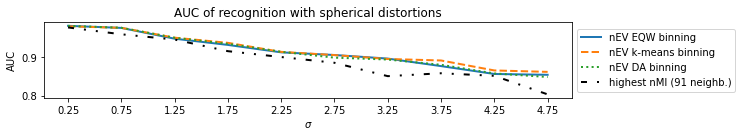

In [393]:
sigma_hist= np.histogram(results_spherical['sigma'], bins=10, range=[0, np.max(results_spherical['sigma']) + 1e-5])
results_spherical['sigma_bin']= np.digitize(results_spherical['sigma'], sigma_hist[1], right=False)

sigma_values= (sigma_hist[1][1:] + sigma_hist[1][:-1])/2

grouped_sigma= results_spherical.groupby(['sigma_bin']).agg(['mean', 'std'])

grouped_sigma= grouped_sigma.loc[list(np.unique(results_spherical['sigma_bin']))]

plt.figure(figsize=figsize)
plt.plot(np.arange(len(grouped_sigma)), grouped_sigma[('eqw_hits', 'mean')], label='nEV EQW binning', linestyle='-', linewidth=2.0)
#plt.plot(np.arange(len(grouped)), grouped[('eqf_hits', 'mean')], label='nEV EQF binning', linewidth=2.0, linestyle='-.')
plt.plot(np.arange(len(grouped_sigma)), grouped_sigma[('kmeans_hits', 'mean')], label='nEV k-means binning', linestyle='--', linewidth=2.0)
plt.plot(np.arange(len(grouped_sigma)), grouped_sigma[('distortion_aligned_hits', 'mean')], label='nEV DA binning', linewidth=2.0, linestyle=':')

nmi_values= []
for i, n in enumerate(mi_n_neighbors_simulation_spherical):
    nmi_values.append(np.mean(grouped_sigma[('mi_' + str(n) + '_hits', 'mean')]))
highest_nmi= mi_n_neighbors_simulation_spherical[np.argmax(nmi_values)]
i= 5
n= highest_nmi
    
plt.plot(np.arange(len(grouped_sigma)), grouped_sigma[('mi_' + str(n) + '_hits', 'mean')], label='highest nMI (' + str(n) + ' neighb.)', linewidth=2.0, linestyle=['-', '-.', '--', ':', (0, (3, 10, 1, 10)), (0, (3, 5, 1, 5, 1, 5)), (0, (3, 1, 1, 1, 1, 1))][i], c='black')

plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.xlabel('$\sigma$')
plt.ylabel('AUC')
plt.title('AUC of recognition with spherical distortions')
plt.xticks(np.arange(len(grouped_sigma)), [str(np.round(s, 2)) for s in sigma_values])
plt.tight_layout()
plt.savefig('sigma_spherical.pdf')

### Executing the statistical tests

In [394]:
means= np.array([np.mean(results_spherical['eqw_hits']), 
                 np.mean(results_spherical['eqf_hits']), 
                 np.mean(results_spherical['kmeans_hits']), 
                 np.mean(results_spherical['distortion_aligned_hits']),
                 np.mean(results_spherical['mi_3_hits']),
                 np.mean(results_spherical['mi_7_hits']),
                 np.mean(results_spherical['mi_11_hits']),
                 np.mean(results_spherical['mi_31_hits']),
                 np.mean(results_spherical['mi_61_hits']),
                 np.mean(results_spherical['mi_91_hits'])])

results_spherical_2= results_spherical[results_spherical['b'] == '2']

binning_methods_mi= binning_methods + ['mi_' + str(i) for i in mi_n_neighbors_simulation_spherical]

p_matrix_spherical= np.zeros(shape=(len(binning_methods_mi), len(binning_methods_mi)))

for i, b0 in enumerate(binning_methods_mi):
    for j, b1 in enumerate(binning_methods_mi):
        p_matrix_spherical[i][j]= ttest_rel(results_spherical_2[b0 + '_hits'], results_spherical_2[b1 + '_hits'])[1]

pd.options.display.float_format = '{:.1e}'.format
p= pd.DataFrame(np.vstack([p_matrix_spherical, means]), 
                columns= binning_methods_mi, 
                index=binning_methods_mi + ['AUC']).fillna(1)

print("the matrix of p-values and mean AUCs for spherical distortions")
print(p.to_latex())

for i, b0 in enumerate(binning_methods_mi):
    for j, b1 in enumerate(binning_methods_mi):
        a= results_spherical_2[b0 + '_hits'].values
        b= results_spherical_2[b1 + '_hits'].values

        for k in [0, 1]:
            for l in [0, 1]:
                table[k,l]= np.sum(np.logical_and(a == k, b == l))

        p_matrix_spherical[i][j]= mcnemar(table).pvalue

pd.options.display.float_format = '{:.1e}'.format
p= pd.DataFrame(np.vstack([p_matrix_spherical, means]), 
                columns= binning_methods_mi, 
                index=binning_methods_mi + ['AUC']).fillna(1)

print("the matrix of p-values and mean AUCs for spherical distortions with mcnemar test")
print(p.to_latex())

the matrix of p-values and mean AUCs for spherical distortions
\begin{tabular}{lrrrrrrrrrr}
\toprule
{} &      eqw &     eqf &   kmeans &  distortion\_aligned &     mi\_3 &     mi\_7 &   mi\_11 &   mi\_31 &   mi\_61 &   mi\_91 \\
\midrule
eqw                &  1.0e+00 & 0.0e+00 &  2.5e-11 &             7.1e-01 & 2.1e-132 &  5.2e-63 & 2.5e-37 & 5.2e-16 & 3.6e-08 & 7.8e-08 \\
eqf                &  0.0e+00 & 1.0e+00 &  0.0e+00 &             0.0e+00 &  0.0e+00 &  0.0e+00 & 0.0e+00 & 0.0e+00 & 0.0e+00 & 0.0e+00 \\
kmeans             &  2.5e-11 & 0.0e+00 &  1.0e+00 &             1.6e-20 & 3.5e-186 & 2.1e-110 & 2.6e-79 & 8.2e-48 & 7.0e-34 & 5.9e-33 \\
distortion\_aligned &  7.1e-01 & 0.0e+00 &  1.6e-20 &             1.0e+00 & 1.4e-124 &  2.8e-60 & 5.8e-36 & 2.9e-14 & 2.5e-07 & 5.6e-07 \\
mi\_3               & 2.1e-132 & 0.0e+00 & 3.5e-186 &            1.4e-124 &  1.0e+00 &  6.3e-24 & 2.0e-43 & 4.0e-74 & 2.9e-91 & 4.6e-91 \\
mi\_7               &  5.2e-63 & 0.0e+00 & 2.1e-110 &             2.8

In [395]:
tmp=results_spherical_2[['b'] + [c for c in results_spherical.columns if c.endswith('hits')]].groupby(['b']).mean().T
print(tmp)

tmp=results_spherical[['b'] + [c for c in results_spherical.columns if c.endswith('hits')]].groupby(['b']).mean().T
print(tmp)
print(tmp.mean(axis=1))

b                             2
eqw_hits                9.1e-01
eqf_hits                4.9e-01
kmeans_hits             9.3e-01
distortion_aligned_hits 9.1e-01
mi_3_hits               8.1e-01
mi_7_hits               8.5e-01
mi_11_hits              8.6e-01
mi_31_hits              8.9e-01
mi_61_hits              9.0e-01
mi_91_hits              9.0e-01
b                             2       5  rice-rule  square-root  \
eqw_hits                9.1e-01 9.3e-01    9.1e-01      9.1e-01   
eqf_hits                4.9e-01 5.0e-01    5.1e-01      5.0e-01   
kmeans_hits             9.3e-01 9.3e-01    9.1e-01      9.0e-01   
distortion_aligned_hits 9.1e-01 9.3e-01    9.1e-01      9.1e-01   
mi_3_hits               8.1e-01 8.0e-01    8.0e-01      8.0e-01   
mi_7_hits               8.5e-01 8.5e-01    8.4e-01      8.4e-01   
mi_11_hits              8.6e-01 8.6e-01    8.6e-01      8.6e-01   
mi_31_hits              8.9e-01 8.9e-01    8.8e-01      8.9e-01   
mi_61_hits              9.0e-01 9.0e-01    9.

## Runtimes

In [396]:
np.mean(results_square_root[[c for c in results_square_root.columns if c.endswith('runtime')]])

eqw_runtime                  8.1e-04
eqf_runtime                  9.7e-04
kmeans_runtime               4.3e-03
distortion_aligned_runtime   5.9e-02
mi_3_runtime                 7.4e-03
mi_7_runtime                 7.9e-03
mi_11_runtime                8.5e-03
mi_21_runtime                9.7e-03
dtype: float64

In [397]:
np.mean(results_spherical[[c for c in results_spherical.columns if c.endswith('runtime')]])

eqw_runtime                  6.5e-04
eqf_runtime                  8.6e-04
kmeans_runtime               3.0e-03
distortion_aligned_runtime   6.6e-02
mi_3_runtime                 7.7e-03
mi_7_runtime                 8.1e-03
mi_11_runtime                8.7e-03
mi_31_runtime                1.1e-02
mi_61_runtime                1.5e-02
mi_91_runtime                1.9e-02
dtype: float64